In [54]:
from pathlib import Path
import torch.utils.data
import random
import torch
import tqdm
import soundfile as sf

from torchaudio import transforms
import librosa
from itertools import product
import numpy as np
import scipy

In [55]:
def generate_label(audio):
        # np, [c, t]
        channels = audio.shape[0]
        rms_fig = librosa.feature.rms(y=audio.numpy()) 
        #[c, 1, 313]

        rms_tensor = torch.tensor(rms_fig).permute(0, 2, 1)
        # [channel, time, 1]
        rms_trim = rms_tensor.expand(-1, -1, 512).reshape(channels, -1)[:, :160000]
        # [channel, time]
        k = int(audio.shape[1]*0.8)
        min_threshold, _ = torch.kthvalue(rms_trim[0, :], k)

        label = (rms_trim > min_threshold).type(torch.float)
        label = torch.Tensor(scipy.ndimage.binary_dilation(label.numpy(), iterations=3)).type(torch.float) 
        
        time = int(audio.shape[1]//1000) # 0.1 sec
        label_index_lst = torch.nonzero((label[:,1:] - label[:,:-1]) == 1).tolist()
        square_labels = torch.zeros_like(label)
        
        for idx in label_index_lst:
            square_labels[idx[0],(idx[1]):(idx[1] + time)] = 1.0
    
        #[channel, time]
        return square_labels, label

In [56]:
 def generate_slider_label(audio):
        # np, [1, 313]
        channels = audio.shape[0]
        rms_fig = librosa.feature.rms(y=audio.numpy())  
        #[c, 1, 313]
        rms_tensor = torch.tensor(rms_fig).permute(0, 2, 1)
        # [channel, time, 1]
        rms_trim = rms_tensor.expand(-1, -1, 512).reshape(channels, -1)[:, :160000]
        # [channel, time]

        min_threshold = (torch.max(rms_trim) + torch.min(rms_trim))/2

        label = (rms_trim > min_threshold).type(torch.float) 
        
        time = int(audio.shape[1]//1000) # 0.1 sec
        label_index_lst = torch.nonzero((label[:,1:] - label[:,:-1]) == 1).tolist()
        square_labels = torch.zeros_like(label)
        
        for idx in label_index_lst:
            square_labels[idx[0],(idx[1] + 1):(idx[1] + time)] = 1.0
    
        #[channel, time]
        return square_labels, label

In [57]:
aueio_file_path = "/hdd/hdd1/mimii/6dB/slider/id_00/normal/00000021.wav"
aueio_file_path2= "/hdd/hdd1/mimii/6dB/slider/id_02/normal/00000100.wav"

In [58]:
np_audio, _ = sf.read(aueio_file_path)
audio = torch.tensor(np_audio.T, dtype=torch.float)[:, :]

np_audio2, _ = sf.read(aueio_file_path2)
audio2 = torch.tensor(np_audio2.T, dtype=torch.float)[:, :]

In [59]:
square_label, label = generate_label(audio)
square_label2, label2 = generate_label(audio2)

In [60]:
print(square_label.shape)
print(audio.shape)

torch.Size([8, 160000])
torch.Size([8, 160000])


In [61]:
print(torch.sum(label[0,:]*label2[0,:]))
print(torch.sum(label[0,:]))
print(label.shape)

tensor(6699.)
tensor(33870.)
torch.Size([8, 160000])


In [62]:
overlap_ratio = torch.sum(label[0,:] * label2[0,:])/label.shape[-1]

overlap_ratio = (torch.sum(label[0,:] * label2[0,:])/torch.sum(label[0,:]) + torch.sum(label[0,:] * label2[0,:])/torch.sum(label[1,:]))/2
print(torch.sum(label[0,:] * label2[0,:])/torch.sum(label[1,:]))
print(overlap_ratio)


tensor(0.1949)
tensor(0.1963)


In [63]:
time = 16000
dur = 10

## plot waveform and activity signal ##

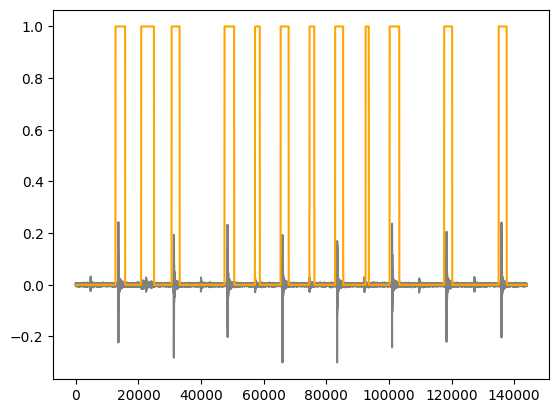

In [64]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(audio[0,time:time*dur], color = 'grey')
# plt.plot(square_label[0,time:time*dur], color = 'green')
plt.plot(label[0,time:time*dur], color = 'orange')
plt.show()

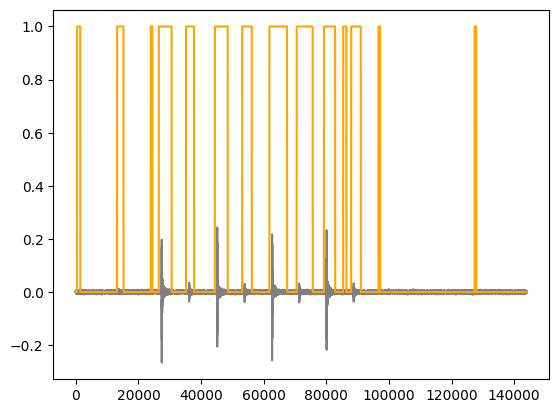

In [65]:
plt.figure()
plt.plot(audio2[0,time:time*dur], color = 'grey')
# plt.plot(square_label[0,time:time*dur], color = 'green')
plt.plot(label2[0,time:time*dur], color = 'orange')
plt.show()